In [1]:
import pandas as pd 
import numpy as np
import datetime as dt 
import copy
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
df = pd.read_excel('D:\Data Intense\Level 3\Round 2 - Data set.xlsx', sheet_name='Purchasing data')

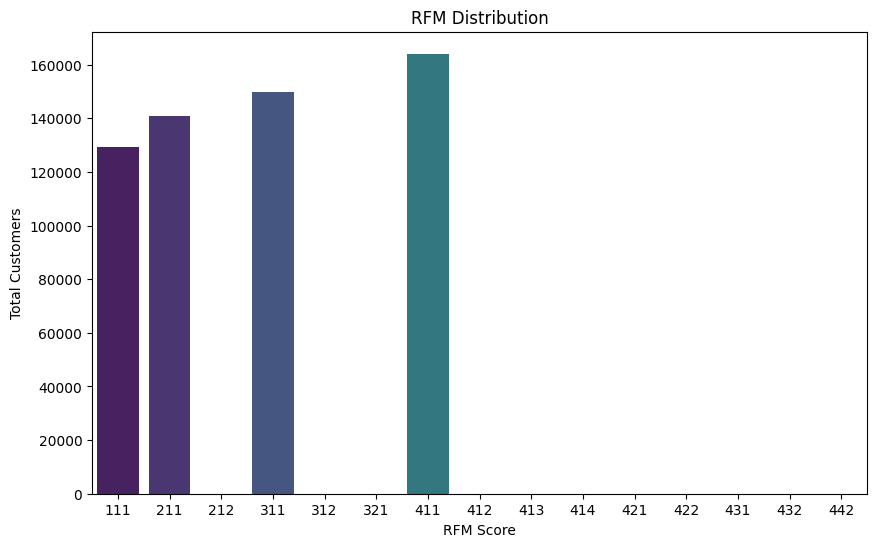

In [3]:
#Reconstruct the data 
df = df.loc[:, ['CustomerID', 'SalesAmount', 'TransactionDate']]
###CALCULATE THE TOTAL GMV
df['Total GMV'] = df.groupby('CustomerID')['SalesAmount'].transform('sum')
#Take out the last order of each customer 
df['Last Order'] = df.groupby('CustomerID')['TransactionDate'].transform('max')

#Transform last order day 
df['Last Order'] = pd.to_datetime(df['Last Order'])
df['Last Order'] = df['Last Order'].dt.strftime('%Y-%m-%d')
df['Last Order'] = pd.to_datetime(df['Last Order'])

#Transform the transaction date
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['TransactionDate'] = df['TransactionDate'].dt.strftime('%Y-%m-%d')
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

#Create the report date
df['Report Date'] = '2023-01-10'
df['Report Date'] = pd.to_datetime(df['Report Date'])

###CALCULATE THE RECENCY 
df['Recency'] = (df['Report Date'] - df['Last Order']).dt.days

###Calculate the frequency 
df['Frequency'] = df.groupby('CustomerID')['TransactionDate'].rank(method='dense', ascending=True)
df['Max Frequency'] = df.groupby('CustomerID')['Frequency'].transform('max')
df['Frequency'] = pd.to_numeric(df['Frequency']).astype('int')

#Calculating the recency score
max_recency = df['Recency'].max()
min_recency = df['Recency'].min()
condlist_r = [
    (df['Recency'] >= min_recency) & (df['Recency'] <= 0.25*max_recency), 
    (df['Recency'] > 0.25*max_recency) & (df['Recency'] <= 0.5*max_recency), 
    (df['Recency'] > 0.5*max_recency) & (df['Recency'] <= 0.75*max_recency), 
    (df['Recency'] > 0.75*max_recency) & (df['Recency'] <= max_recency)
]

choicelist_r = [4, 3, 2, 1]

df['R'] = np.select(condlist_r, choicelist_r)

#Calculating the frequency score 
max_frequency = df['Frequency'].max()
min_frequency = df['Frequency'].min()
condlist_f = [
    (df['Frequency'] >= min_frequency) & (df['Frequency'] <= 0.25*max_frequency), 
    (df['Frequency'] > 0.25*max_frequency) & (df['Frequency'] <= 0.5*max_frequency), 
    (df['Frequency'] > 0.5*max_frequency) & (df['Frequency'] <= 0.75*max_frequency), 
    (df['Frequency'] > 0.75*max_frequency) & (df['Frequency'] <= max_frequency)
]
choicelist_f = [1, 2, 3, 4]

df['F'] = np.select(condlist_f, choicelist_f)

#Calculating the monetary score 
max_monetary = df['Total GMV'].max() 
min_monetary = df['Total GMV'].min()
condlist_m = [
    (df['Total GMV'] >= min_monetary) & (df['Total GMV'] <= 0.25*max_monetary), 
    (df['Total GMV'] > 0.25*max_monetary) & (df['Total GMV'] <= 0.5*max_monetary), 
    (df['Total GMV'] > 0.5*max_monetary) & (df['Total GMV'] <= 0.75*max_monetary), 
    (df['Total GMV'] > 0.75*max_monetary) & (df['Total GMV'] <= max_monetary)
]
choicelist_m = [1, 2, 3, 4]

df['M'] = np.select(condlist_m, choicelist_m)

df['RFM'] = df['R'].astype('str') + df['F'].astype('str') + df['M'].astype('str')

df['RFM'] = pd.to_numeric(df['RFM'])

result = copy.deepcopy(df)
result = result.sort_values('TransactionDate').drop_duplicates('CustomerID', keep='last')

result = result.loc[:, ['CustomerID', 'Total GMV', 'Last Order', 'Frequency', 'RFM']]

plt.figure(figsize=(10, 6))

sns.countplot(x='RFM', data=result, palette='viridis')
plt.title('RFM Distribution')

plt.xlabel('RFM Score')
plt.ylabel('Total Customers')

plt.show()

In [ ]:
import torch 
from torch import nn 
from torch.utils.data import TensorDataset, DataLoader 
from sklearn.preprocessing import StandardScaler 
data = copy.deepcopy(result)

In [4]:
# import torch 
# from torch import nn 
# from torch.utils.data import TensorDataset, DataLoader 
# from sklearn.preprocessing import StandardScaler 

# data = copy.deepcopy(result)

# #Make a scaler 
# scaler = StandardScaler() 

# data['DOW'] = data['Last Order'].dt.dayofweek
# input_data = data.loc[:, ['Total GMV', 'Frequency', 'DOW']]
# input_data = input_data.values
# input_data = torch.tensor(input_data, dtype=torch.float32)

# scaler.fit(input_data)

# dict_label = {}
# list_label = data.loc[:, 'RFM']
# list_label = list_label.unique()
# list_label = list(list_label)
# for index, label in enumerate(list_label): 
#     dict_label[label] = index
# dict_label

# result_label = {} 
# for index, label in enumerate(list_label): 
#     result_label[index] = label 

# data['RFM Label'] = data['RFM'].map(dict_label)
# label_data = data['RFM Label'].values
# label_data = torch.tensor(label_data, dtype=torch.float32)

# proportion = int(0.8*len(input_data)) 
# train_input, train_output = input_data[:proportion], label_data[:proportion]
# train_input = scaler.transform(train_input)
# train_input = torch.tensor(train_input, dtype=torch.float32)
# test_input, test_output = input_data[proportion:], label_data[proportion:]

# BATCH_SIZE = 64
# train_dataset = TensorDataset(train_input, train_output)
# train_dataloader = DataLoader(dataset=train_dataset,
#                               batch_size=BATCH_SIZE,
#                               shuffle=True)

# test_dataset = TensorDataset(test_input, test_output)
# test_dataloader = DataLoader(dataset=test_dataset,
#                              batch_size=BATCH_SIZE,
#                              shuffle=False)

# #Create the neural network 
# class pizzamodel(nn.Module): 
#     def __init__(self, class_weight=None): 
#         super().__init__()
#         self.stacked_layer = nn.Sequential(
#             nn.Linear(in_features=3, out_features=64),
#             nn.ReLU(), 
#             nn.Linear(in_features=64, out_features=32), 
#             nn.ReLU(), 
#             nn.Linear(in_features=32, out_features=15)
#         )
#         self.class_weight = class_weight
    
#     def forward(self, x): 
#         return self.stacked_layer(x)

# class_weights = {
#     '111': 5, 
#     '211': 5, 
#     '311': 5, 
#     '411': 5,
#     'others': 3
# }

# #Initialize the model 
# model = pizzamodel(class_weight=class_weights) 
# learning_rate = 0.1
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# loss_fn = nn.CrossEntropyLoss() 
# def acc_fn(y_pred, y_true): 
#     correct = torch.eq(y_pred, y_true).sum().item()
#     acc = (correct / len(y_pred)) * 100
#     return acc 

# #Create the traning and testing model
# epoches = 10
# for epoch in range(epoches): 
#     print(f'Epoch {epoch}\n ----') 
#     ###TRAINING MODEL
#     model.train() 
#     for batch, (train_features, train_labels) in enumerate(train_dataloader): 
#         #1. Pass to the forward 
#         train_pred = model(train_features)

#         #2. Calculate the loss 
#         train_loss = loss_fn(train_pred, train_labels.type(torch.long))

#         #3. Backward propagation on the loss 
#         train_loss.backward() 

#         #4. Gradient descending 
#         optimizer.step() 

#         #5. Zero out the gradient 
#         optimizer.zero_grad() 

#         if batch % 5000 == 0: 
#             print(f'Looked at {batch * len(train_features)}/{len(train_dataloader.dataset)} samples')
    
#     ###TESTING MODEL 
#     model.eval()
#     with torch.no_grad(): 
#         for test_features, test_labels in test_dataloader: 
#             #1. Pass to the forward 
#             test_pred = model(test_features)

#             #2. Calculate the loss and accuracy 
#             test_loss = loss_fn(test_pred, test_labels.type(torch.long))
#             test_acc = acc_fn(y_pred=torch.argmax(torch.softmax(test_pred, dim=1), dim=1),
#                               y_true=test_labels)
            
#     print(f'Train loss {train_loss.item():.4f} | Test loss {test_loss.item():.4f} | Test accuracy {test_acc}')


Epoch 0
 ----
Looked at 0/466913 samples


KeyboardInterrupt: 

In [ ]:
len(data)
length_111 = len(data.loc[data['RFM'] == 111, :])
length_211 = len(data.loc[data['RFM'] == 211, :])
length_311 = len(data.loc[data['RFM'] == 311, :])
length_411 = len(data.loc[data['RFM'] == 411, :])
print(f'Total score at 111: {length_111}') 
print(f'Total score at 211: {length_211}')
print(f'Total score at 311: {length_311}') 
print(f'Total score at 411: {length_411}')
print(f'Total score of these 4 RFM scores {length_111 + length_211 + length_311 + length_411}')
print(f'Total score RFM: {len(data)}')

Total score at 111: 129136
Total score at 211: 140772
Total score at 311: 149595
Total score at 411: 164046
Total score of these 4 RFM scores 583549
Total score RFM: 583642


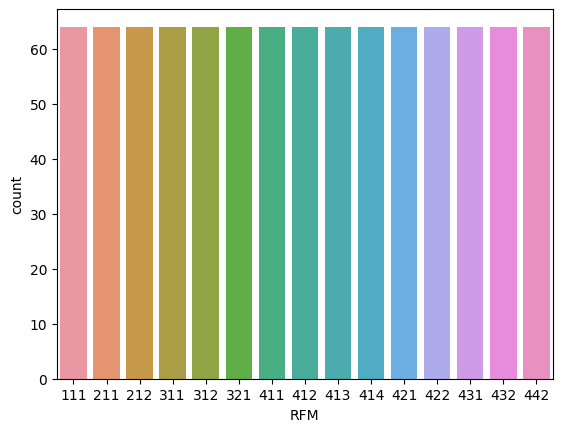

In [149]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() 

cond = (df['RFM'] == 111) | (df['RFM'] == 211) | (df['RFM'] == 311) | (df['RFM'] == 411)
dominant_data = copy.deepcopy(data.loc[cond, :])
dominant_input = dominant_data.loc[:, ['DOW', 'Frequency', 'Total GMV']]
# dominant_input = torch.tensor(dominant_input, dtype=torch.float32)

others_data = copy.deepcopy(data.loc[~cond, :])
others_input = others_data.loc[:, ['Total GMV', 'Frequency', 'DOW']]
others_output = others_data.loc[:, ['RFM']]
ros = RandomOverSampler(sampling_strategy="auto", random_state=42)
x_resampled, y_resampled = ros.fit_resample(others_input, others_output)

dominant_indices = dominant_input.index 
np.random.seed(42)
sampled_indices = np.random.choice(dominant_indices, size=704, replace=False)
sampled_indices = list(sampled_indices)
reduced_dominant = dominant_data.loc[sampled_indices]
reduced_input = reduced_dominant.loc[:, ['Total GMV', 'Frequency', 'DOW']]
reduced_output = reduced_dominant.loc[:, ['RFM']]

pre_input_data = np.concatenate((reduced_input.values, x_resampled.values), axis=0)
pre_output_data = np.concatenate((y_resampled.values, reduced_output.values), axis=0)

test_df = pd.DataFrame()
test_df[['Total GMV', 'Frequency', 'DOW']] = pre_input_data
test_df['RFM'] = pre_output_data

index_411 = test_df.loc[test_df['RFM'] == 411, :].index
np.random.seed(42)
drop_411 = len(index_411) - 64
indices_411_to_drop = np.random.choice(index_411, size=drop_411, replace=False)
test_df.drop(indices_411_to_drop, inplace=True)

index_312 = test_df.loc[test_df['RFM'] == 311, :].index
np.random.seed(42)
drop_312 = len(index_312) - 64
indices_312_to_drop = np.random.choice(index_312, size=drop_312, replace=False)
test_df.drop(indices_312_to_drop, inplace=True)

index_211 = test_df.loc[test_df['RFM'] == 211, :].index
np.random.seed(42)
drop_211 = len(index_211) - 64
indices_211_to_drop = np.random.choice(index_211, size=drop_211, replace=False)
test_df.drop(indices_211_to_drop, inplace=True)

index_111 = test_df.loc[test_df['RFM'] == 111, :].index
np.random.seed(42)
drop_111 = len(index_111) - 64
indices_111_to_drop = np.random.choice(index_111, size=drop_111, replace=False)
test_df.drop(indices_111_to_drop, inplace=True)

matching_dict = {}
unique_label = list(np.unique(pre_output_data))
for index, values in enumerate(unique_label):
    matching_dict[values] = index 

test_df['RFM Label'] = test_df['RFM'].map(matching_dict)

input_data = test_df.loc[:, ['Total GMV', 'Frequency', 'DOW']].values
output_data = test_df.loc[:, 'RFM Label'].values

scaler.fit(input_data)

proportion = int(0.8*len(input_data)) 
train_input, train_label = input_data[:proportion], output_data[:proportion]
train_input = scaler.transform(train_input) 
test_input, test_label = input_data[proportion:], output_data[proportion:]

train_input, train_label = torch.tensor(train_input, dtype=torch.float32).clone().detach(), torch.tensor(train_label, dtype=torch.float32).clone().detach()
test_input, test_label = torch.tensor(test_input, dtype=torch.float32).clone().detach(), torch.tensor(test_label, dtype=torch.float32).clone().detach()

train_dataset = TensorDataset(train_input, train_label)

BATCH_SIZE = 32 
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataset = TensorDataset(test_input, test_label)
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

class pizzamodel(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.stacked_layer = nn.Sequential(
            nn.Linear(in_features=3, out_features=256),
            nn.ReLU(), 
            nn.Linear(in_features=256, out_features=256), 
            nn.ReLU(), 
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=15)
        )

    def forward(self, x): 
        return self.stacked_layer(x)
    
sns.countplot(x='RFM', data=test_df)
plt.show()

In [148]:
#Initialize the model 
model = pizzamodel() 
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() 
def acc_fn(y_pred, y_true): 
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc 

#Create the traning and testing model
epoches = 1000
for epoch in range(epoches): 
    print(f'Epoch {epoch}\n ----') 
    ###TRAINING MODEL
    model.train() 
    for batch, (train_features, train_labels) in enumerate(train_dataloader): 
        #1. Pass to the forward 
        train_pred = model(train_features)

        #2. Calculate the loss 
        train_loss = loss_fn(train_pred, train_labels.type(torch.long))

        #3. Backward propagation on the loss 
        train_loss.backward() 

        #4. Gradient descending 
        optimizer.step() 

        #5. Zero out the gradient 
        optimizer.zero_grad() 

        if batch % 5000 == 0: 
            print(f'Looked at {batch * len(train_features)}/{len(train_dataloader.dataset)} samples')
    
    ###TESTING MODEL 
    model.eval()
    with torch.inference_mode(): 
        for test_features, test_labels in test_dataloader: 
            #1. Pass to the forward 
            test_pred = model(test_features)

            #2. Calculate the loss and accuracy 
            test_loss = loss_fn(test_pred, test_labels.type(torch.long))
            test_acc = acc_fn(y_pred=torch.argmax(torch.softmax(test_pred, dim=1), dim=1),
                              y_true=test_labels)
            
    print(f'Train loss {train_loss.item():.4f} | Test loss {test_loss.item():.4f} | Test accuracy {test_acc}')



Epoch 0
 ----
Looked at 0/768 samples
Train loss 2.6985 | Test loss 1223720.0000 | Test accuracy 0.0
Epoch 1
 ----
Looked at 0/768 samples
Train loss 2.6941 | Test loss 1417735.5000 | Test accuracy 0.0
Epoch 2
 ----
Looked at 0/768 samples
Train loss 2.6791 | Test loss 1601372.5000 | Test accuracy 0.0
Epoch 3
 ----
Looked at 0/768 samples
Train loss 2.6600 | Test loss 1783205.2500 | Test accuracy 0.0
Epoch 4
 ----
Looked at 0/768 samples
Train loss 2.6740 | Test loss 1965824.1250 | Test accuracy 0.0
Epoch 5
 ----
Looked at 0/768 samples
Train loss 2.6716 | Test loss 2153087.5000 | Test accuracy 0.0
Epoch 6
 ----
Looked at 0/768 samples
Train loss 2.6417 | Test loss 2341371.5000 | Test accuracy 0.0
Epoch 7
 ----
Looked at 0/768 samples
Train loss 2.6393 | Test loss 2582358.5000 | Test accuracy 0.0
Epoch 8
 ----
Looked at 0/768 samples
Train loss 2.6435 | Test loss 2829494.5000 | Test accuracy 0.0
Epoch 9
 ----
Looked at 0/768 samples
Train loss 2.6535 | Test loss 3069503.5000 | Test acc